In [15]:
from imports import *

In [54]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
import time

# Preprocessing
Load the dataset. IF is then run on samples of the dataset with different anomaly rates.

In [19]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%}")

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

dfsf_normed = preprocessing.normalize(dfsf.drop(["target", 'binary_target'], axis=1))

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(dfsf_normed, dfsf['binary_target'], test_size=0.33, random_state=0)

SF anomaly rate is 4.5%


In [55]:
sa = datasets.fetch_kddcup99(subset='SA', percent10=True, random_state=0)
dfsa = pd.DataFrame(sa.data, columns=sa_columns)
dfsa["target"]=sa.target
anomaly_rate =  1.0 - len(dfsa.loc[dfsa["target"]==b'normal.'])/len(dfsa)
print(f"SA anomaly rate is {anomaly_rate:.1%}")

dfsa['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsa["target"]]
toDecodeSA = ["protocol_type", "service", "flag", "target"]
le = preprocessing.LabelEncoder()
for f in toDecodeSA:
    dfsa[f] = list(map(byte_decoder, dfsa[f]))
    dfsa[f] = le.fit_transform(dfsa[f])

X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(dfsa.drop(["target", 'binary_target'], axis=1), dfsa['binary_target'], test_size=0.25, random_state=0)

SA anomaly rate is 3.4%


In [65]:
r = 0.01
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.1, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 1.0% out of 98261 records (983)


In [66]:
r = 0.02
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.2, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 2.0% out of 198527 records (3971)


In [59]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score, pos_label=-1), 'F1': make_scorer(fbeta_score, labels=[-1], average='macro', beta=0.5)}
gs = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs.fit(X_train_sf, y_train_sf)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm = gs.cv_results_

stime = time.time()
y_pred = gs.predict(X_test_sf)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 260.066
Time for OCSVM prediction: 0.194


In [60]:
gs_sa = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa = gs.cv_results_

stime = time.time()
y_pred = gs_sa.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 2996.328
Time for OCSVM prediction: 5.784


In [ ]:
gs_sa_poly = GridSearchCV(OneClassSVM(kernel="poly"),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05),
                             'gamma': ['scale', 'auto'],
                             'degree': np.array([2,3,4])},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_poly.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_poly = gs_sa_poly.cv_results_

stime = time.time()
y_pred = gs_sa_poly.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

In [ ]:
gs_sa_poly = GridSearchCV(OneClassSVM(kernel="sigmoid", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_poly.fit(X_train_sa, y_train_sa)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_poly = gs_sa_poly.cv_results_

stime = time.time()
y_pred = gs_sa_poly.predict(X_test_sa)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

In [68]:
gs_sa_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_1.fit(x_train_1, y_train_1)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa_1 = gs_sa_1.cv_results_

stime = time.time()
y_pred = gs_sa_1.predict(x_test_1)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 2107.779
Time for OCSVM prediction: 1.039


In [69]:
gs_sa_2 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                  param_grid={'nu': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='F1')
stime = time.time()
gs_sa_2.fit(x_train_2, y_train_2)
print("Time for OCSVM fitting: %.3f" % (time.time() - stime))
results_svm_sa = gs_sa_2.cv_results_

stime = time.time()
y_pred = gs_sa_2.predict(x_test_2)
print("Time for OCSVM prediction: %.3f" % (time.time() - stime))

Time for OCSVM fitting: 12059.687
Time for OCSVM prediction: 25.436


In [80]:
fit_time = [260.066, 2996.328, 2107.779, 12059.687]

<ipython-input-81-68d2061ab5f3>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


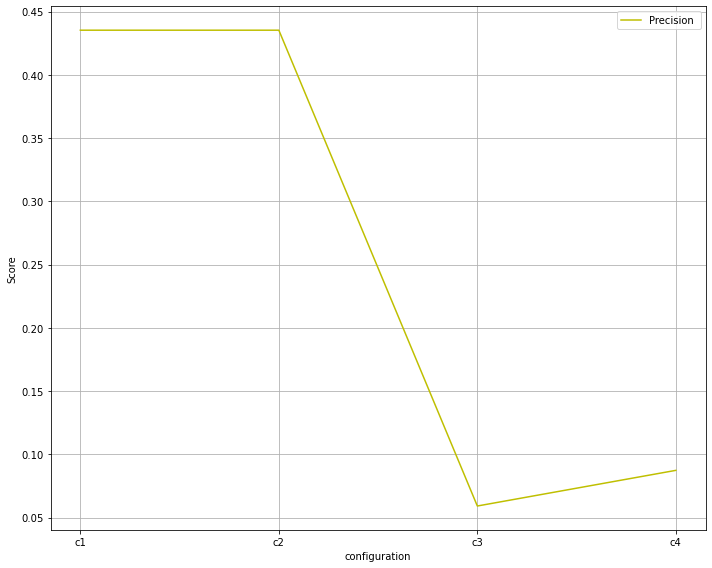

In [81]:
# X_axis = np.array(results_svm["param_nu"].data, dtype=float)
# print GridSearch cross-validation for parameters
X_axis_if = np.array(results_if["param_contamination"].data, dtype=float)
plt.figure(figsize=(10,8))

plt.xlabel("configuration")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
pad = 0.005

colors = {'lof': 'r', 'if':'b', 'dbscan':'c', 'svm':'y'}
scorer = 'Precision'

best_index = np.nonzero(results_svm['rank_test_%s' % scorer] == 1)[0][0]
best_score_svm = results_svm['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa['rank_test_%s' % scorer] == 1)[0][0]
best_score_sa = results_svm_sa['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_svm_sa_1['mean_test_%s' % scorer][best_index]

best_index = np.nonzero(results_svm_sa_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_svm_sa_2['mean_test_%s' % scorer][best_index]

Y_axis = np.array([best_score_svm, best_score_sa, best_score_1, best_score_2])
X_axis = np.array(['c1', 'c2', 'c3', 'c4'])

ax.plot(X_axis, Y_axis, '-', color=colors['svm'],label="%s " % (scorer))
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("nu.png", dpi=100)

plt.show()

# for scorer, color in zip(sorted(scoring), ['b', 'k']):
#     sample, style= ('test', '-')
#     sample_score_mean = results_svm['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std = results_svm['std_%s_%s' % (sample, scorer)]
    
#     sample_score_mean_lof = results_lof['mean_%s_%s' % (sample, scorer)]
# #    sample_score_std_lof = results_lof['std_%s_%s' % (sample, scorer)]
    
# #     We don't plot standard deviation    
# #     ax.fill_between(X_axis, sample_score_mean - sample_score_std,
# #                 sample_score_mean + sample_score_std,
# #                 alpha=0.1 if sample == 'test' else 0, color=color)
#     ax.plot(X_axis, sample_score_mean, style, color=color,
#         alpha=1 if sample == 'test' else 0.7,
#         label="%s (%s)" % (scorer, sample))

#     best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#     best_score = results['mean_test_%s' % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#         linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score,
#             (X_axis[best_index], best_score+pad))
    
# plt.legend(loc="best")
# plt.grid('off')
# plt.tight_layout()
# plt.savefig("nu.png", dpi=100)

# plt.show()

# Archive

In [63]:
results_svm

{'mean_fit_time': array([ 0.61091375,  5.07705498,  9.18493633, 13.29303331, 16.88273849]),
 'std_fit_time': array([0.01198042, 0.12844537, 0.08549168, 0.08558367, 0.30675319]),
 'mean_score_time': array([0.1449966 , 0.74371862, 1.3358501 , 1.94709306, 2.59730806]),
 'std_score_time': array([0.00463848, 0.01713212, 0.01801429, 0.02144899, 0.06321599]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.94115565, 0.91135687, 0.91014531, 0.89717969, 0.93749916]),
 'split1_test_AUC': array([0.95307346, 0.92250814, 0.91347697, 0.8959531 , 0.93966566]),
 'split2_test_AUC': array([0.95114229, 0.92344162, 0.9168717 , 0.9012755 , 0.93832205]),
 'sp

In [70]:
results_svm_sa = gs.cv_results_
results_svm_sa

{'mean_fit_time': array([ 0.61091375,  5.07705498,  9.18493633, 13.29303331, 16.88273849]),
 'std_fit_time': array([0.01198042, 0.12844537, 0.08549168, 0.08558367, 0.30675319]),
 'mean_score_time': array([0.1449966 , 0.74371862, 1.3358501 , 1.94709306, 2.59730806]),
 'std_score_time': array([0.00463848, 0.01713212, 0.01801429, 0.02144899, 0.06321599]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.94115565, 0.91135687, 0.91014531, 0.89717969, 0.93749916]),
 'split1_test_AUC': array([0.95307346, 0.92250814, 0.91347697, 0.8959531 , 0.93966566]),
 'split2_test_AUC': array([0.95114229, 0.92344162, 0.9168717 , 0.9012755 , 0.93832205]),
 'sp

In [53]:
results_if

{'mean_fit_time': array([2.36972971, 2.23002892, 2.23278694, 2.26178975, 2.20120721]),
 'std_fit_time': array([0.35499806, 0.04266414, 0.04018767, 0.06024252, 0.02619915]),
 'mean_score_time': array([1.02248826, 1.01561413, 1.01032758, 1.01449027, 0.98523035]),
 'std_score_time': array([0.03878348, 0.03293335, 0.03019608, 0.08170886, 0.02489543]),
 'param_contamination': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'contamination': 0.01},
  {'contamination': 0.060000000000000005},
  {'contamination': 0.11},
  {'contamination': 0.16000000000000003},
  {'contamination': 0.21000000000000002}],
 'split0_test_AUC': array([0.87293722, 0.87293722, 0.87293722, 0.87293722, 0.87293722]),
 'split1_test_AUC': array([0.87041117, 0.87041117, 0.87041117, 0.87041117, 0.87041117]),
 'split2_test_AUC': array([0.880

In [71]:
results_svm_sa_1

{'mean_fit_time': array([  3.15310521,  42.07081943,  78.29551282, 112.87918234,
        146.41757412]),
 'std_fit_time': array([0.04969832, 0.3443859 , 0.5249806 , 1.44938901, 1.82195756]),
 'mean_score_time': array([ 0.70274234,  4.20767879,  7.52159572, 10.85573292, 14.25604572]),
 'std_score_time': array([0.03234505, 0.159796  , 0.03570407, 0.12898077, 0.12571462]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.78775349, 0.79479753, 0.80760556, 0.79655984, 0.78935081]),
 'split1_test_AUC': array([0.78493623, 0.79004843, 0.79999716, 0.79676182, 0.78783564]),
 'split2_test_AUC': array([0.74577745, 0.75972126, 0.76601837, 0.77492016, 

In [73]:
results_svm_sa_2 = gs_sa_2.cv_results_
results_svm_sa_2

{'mean_fit_time': array([154.23872514, 241.91987371, 485.70241013, 596.96554732,
        670.873102  ]),
 'std_fit_time': array([164.24436164, 100.47818039,  63.7203627 , 101.96003818,
         18.59338774]),
 'mean_score_time': array([ 2.8996356 , 17.1722085 , 31.82961888, 44.81605072, 59.74999189]),
 'std_score_time': array([0.11708601, 0.27358993, 0.43767576, 1.05497233, 1.08656381]),
 'param_nu': masked_array(data=[0.01, 0.060000000000000005, 0.11, 0.16000000000000003,
                    0.21000000000000002],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nu': 0.01},
  {'nu': 0.060000000000000005},
  {'nu': 0.11},
  {'nu': 0.16000000000000003},
  {'nu': 0.21000000000000002}],
 'split0_test_AUC': array([0.77804472, 0.78739991, 0.78571251, 0.79789526, 0.78842519]),
 'split1_test_AUC': array([0.76379205, 0.77314981, 0.79521723, 0.78525999, 0.78128722]),
 'split2_test_AUC': array([0.77350027, 0.77824086, 0.7909